# **Car Features and B-Box Detection**


In [ ]:
import kagglehub

path = kagglehub.dataset_download("renancostaalencar/compcars")
print("Path to dataset files:", path)

!mv /root/.cache/kagglehub/datasets/renancostaalencar/compcars/versions/1/ .

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls drive/MyDrive/DeepLearning_uniCourse_proj/models_epochBased/

fasterRCNN_modelEpoch_0.pth  fasterRCNN_modelEpoch_3.pth  fasterRCNN_modelEpoch_6.pth
fasterRCNN_modelEpoch_1.pth  fasterRCNN_modelEpoch_4.pth  fasterRCNN_modelEpoch_7.pth
fasterRCNN_modelEpoch_2.pth  fasterRCNN_modelEpoch_5.pth  faster_rcnn_vehicle_model.pth


In [ ]:
import scipy.io as sio

mat_data = sio.loadmat('/content/1/misc/car_type.mat')
print(mat_data.keys())  # Print the variables in the .mat file
my_variable = mat_data['types']  # Access a specific variable

dict_keys(['__header__', '__version__', '__globals__', 'types'])


In [ ]:
mat_data = sio.loadmat('/content/1/misc/make_model_name.mat')
print(mat_data.keys())  # Print the variables in the .mat file
[list([ind+1,i[0][0]]) for ind, i in enumerate(mat_data['make_names'])]

dict_keys(['__header__', '__version__', '__globals__', 'make_names', 'model_names'])


[[1, 'ABT'],
 [2, 'BAC'],
 [3, 'Conquest'],
 [4, 'DS'],
 [5, 'Dacia'],
 [6, 'Fisker'],
 [7, 'GMC'],
 [8, 'Gumpert'],
 [9, 'Hennessey'],
 [10, 'Icona'],
 [11, 'Jeep'],
 [12, 'KTM'],
 [13, 'MELKUS'],
 [14, 'MG'],
 [15, 'MINI'],
 [16, 'Mazzanti'],
 [17, 'Noble'],
 [18, 'PGO'],
 [19, 'SPIRRA'],
 [20, 'SSC'],
 [21, 'Scion'],
 [22, 'TESLA'],
 [23, 'TVR'],
 [24, 'Tramontana'],
 [25, 'Zenvo'],
 [26, 'smart'],
 [27, 'Yiqi'],
 [28, 'Mitsubishi'],
 [29, 'Shangqidatong'],
 [30, 'Spyker N.V.'],
 [31, 'Dongnan'],
 [32, 'Dongfeng'],
 [33, 'Dongfengxiaokang'],
 [34, 'Dongfengfengdu'],
 [35, 'Dongfengfengshen'],
 [36, 'Dongfengfengxing'],
 [37, 'Zxauto'],
 [38, 'Zhonghua'],
 [39, 'Toyota'],
 [40, 'Zinoro'],
 [41, 'Jiulong'],
 [42, 'Isuzu'],
 [43, 'Wuling'],
 [44, 'AC Chnitzer'],
 [45, 'Zoyte'],
 [46, 'Iveco'],
 [47, 'Bufori'],
 [48, 'Porsche'],
 [49, 'Mitsuoka'],
 [50, 'Chrysler'],
 [51, 'Lamorghini '],
 [52, 'Kombat'],
 [53, 'Cadillac'],
 [54, 'Buck'],
 [55, 'Lifan'],
 [56, 'Lorinser'],
 [57, 'Rolls-R

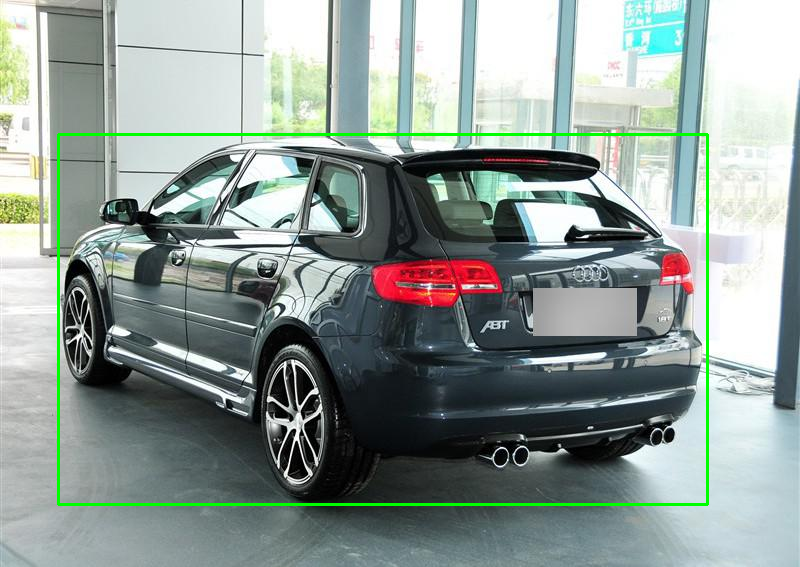

In [ ]:
import cv2
from google.colab.patches import cv2_imshow # Import the cv2_imshow function
image_path = '/content/dataset/image/1/1101/2011/6632ec1c2f7f87.jpg'  # Replace with your image path
image = cv2.imread(image_path)
bbox = [58, 134, 707, 504]  # Replace with your coordinates
cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)  # Green box with thickness of 2

cv2_imshow( image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [ ]:
[list([ind+1, i[0]]) for ind, i in enumerate(my_variable[0])]

[[1, 'MPV'],
 [2, 'SUV'],
 [3, 'sedan'],
 [4, 'hatchback'],
 [5, 'minibus'],
 [6, 'fastback'],
 [7, 'estate'],
 [8, 'pickup'],
 [9, 'hardtop convertible'],
 [10, 'sports'],
 [11, 'crossover'],
 [12, 'convertible']]

train/images': 12949 <br>
test/images': 1618    <br>
valid/images': 1618

In [ ]:
from PIL import Image
import os
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import numpy as np

class Dataset_cars(torch.utils.data.Dataset):
    def __init__(self, root_dir="/content/dataset", data='train', test_size=0.2, transform=None, device='cuda'):
        self.root_dir = root_dir
        self.device = device
        with open(os.path.join(root_dir, 'train_test_split/classification/train.txt'), 'r') as f:
            paths = f.read().splitlines()
        with open(os.path.join(root_dir, 'train_test_split/classification/test.txt'), 'r') as f:
            paths1 = f.read().splitlines()
        paths = paths + paths1
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, 'image', path) for path in paths]
        self.label_paths = [os.path.join(root_dir, 'label', path[:-3]+"txt") for path in paths]

        with open(os.path.join(root_dir, 'misc/attributes.txt'), 'r') as f:
          lines = f.read().splitlines()
        self.label_att = {}
        for i in lines[1:-1]:
          i = i.split(" ")
          self.label_att[int(i[0])] = [int(i[0]), int(i[1]), float(i[2])*10, int(i[3]), int(i[4]), int(i[5])]
        # self.label_att = {int(i[0]): [int(i[0]), int(i[1]), float(i[2]), int(i[3]), int(i[4]), int(i[5])] for i in lines[1:-1]}
        x_train, x_test, y_train, y_test = train_test_split(self.image_paths, self.label_paths, test_size=test_size, random_state=42)
        if data == 'train':
            self.image_paths = x_train
            self.label_paths = y_train
        elif data == 'test':
            self.image_paths = x_test
            self.label_paths = y_test



    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        label_path = self.label_paths[idx]
        image = Image.open(self.image_paths[idx])
        target={}

        with open(label_path, 'r') as f:
            lines = f.read().splitlines()
            if len(lines)>=3:
              box = [int(i) for i in lines[2].split(" ")]
            else:
              print(f"Warning: Unexpected format in label file: {label_path}")
              label=0
              box = [0,0,0,0]
        target['boxes'] = torch.tensor(box, dtype=torch.float32)
        target['labels'] = torch.tensor(self.label_att[int(label_path.split("/")[-3])][-1], dtype=torch.int64)

        if self.transform:
            image = self.transform(image)

        return image, target

In [ ]:
train_dataset = Dataset_cars()
print(len(train_dataset))
train_dataset[0][1]

24764


{'boxes': tensor([ 74., 235., 853., 509.]), 'labels': tensor(3)}

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import VOCDetection  # Or create your own dataset class

# Prepare dataset and transforms
transform = transforms.Compose([
    transforms.Resize((626, 908)),  # Resize images to a fixed size
    transforms.ToTensor(),  # Convert image to tensor
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define dataset and dataloader
dataset = Dataset_cars(data='train', test_size=0.2, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Load pre-trained Faster R-CNN model and modify it for our task
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 13  # 1 Background + 12 vehicle class
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load('/content/drive/MyDrive/DeepLearning_uniCourse_proj/models_epochBased/fasterRCNN_modelEpoch_6.pth'))
# Train the model
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model.to(device)
overall_loss={}
for epoch in range(7,10):
    print(f"epoch: {epoch},", end="\t")
    count=0
    epoch_loss=[]
    for images, targets in dataloader:
        count+=1
        images = list(image.to(device) for image in images)
        # targets = {'boxes': targets['boxes'].to(device), 'labels': targets['labels'].to(device)}
        targets1=[]
        for i in range(targets['boxes'].shape[0]):
          targets1.append({'boxes': targets['boxes'][i].to(device).unsqueeze(0), 'labels': targets['labels'][i].to(device).unsqueeze(0)})
        # print(targets1)
        optimizer.zero_grad()
        loss_dict = model(images, targets1)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        epoch_loss.append(losses.item())
        if count%100==0:
          print(f"{count}({(losses.item()):.3f})", end=" ")

    torch.save(model.state_dict(), f'drive/MyDrive/DeepLearning_uniCourse_proj/models_epochBased/fasterRCNN_modelEpoch_{epoch}.pth')
    overall_loss[epoch]=np.mean(epoch_loss)
    print(f"overall loss: {overall_loss[epoch]}")



In [ ]:
1:20:00

In [ ]:
torch.save(model.state_dict(), f'drive/MyDrive/DeepLearning_uniCourse_proj/models_epochBased/fasterRCNN_modelEpoch_{1}.pth')

In [ ]:
torch.save(model.state_dict(), 'faster_rcnn_vehicle_model_1.pth')

In [ ]:
epoch: 0,	100(0.145) 200(0.119) 300(0.125) 400(0.112) 500(0.159) 600(0.118) 700(0.113) 800(0.110) 900(0.060) 1000(0.081) 1100(0.100) 1200(0.088) 1300(0.082) 1400(0.085) 1500(0.062) 1600(0.076) 1700(0.072) 1800(0.103) 1900(0.079) 2000(0.083) 2100(0.053) 2200(0.083) 2300(0.073) 2400(0.083) 2500(0.103) 2600(0.116) 2700(0.037) 2800(0.065) 2900(0.057) 3000(0.100) overall loss: 0.09117497608320696
epoch: 1,	100(0.076) 200(0.062) 300(0.032) 400(0.055) 500(0.050) 600(0.055) 700(0.032) 800(0.073) 900(0.024) 1000(0.050) 1100(0.059) 1200(0.057) 1300(0.028) 1400(0.055) 1500(0.041) 1600(0.033) 1700(0.057) 1800(0.040) 1900(0.058) 2000(0.048) 2100(0.102) 2200(0.042) 2300(0.062) 2400(0.034) 2500(0.059) 2600(0.068) 2700(0.060) 2800(0.046) 2900(0.071) 3000(0.058) overall loss: 0.05240225853026635
epoch: 2,                                                                                                                                                                                                                                        2100(0.057) 2200(0.048) 2300(0.035) 2400(0.031) 2500(0.028) 2600(0.034) 2700(0.037) 2800(0.038) 2900(0.040) 3000(0.049) overall loss: 0.03769629434920631
epoch: 3,	100(0.025) 200(0.029) 300(0.046) 400(0.028) 500(0.035) 600(0.047) 700(0.046) 800(0.046) 900(0.035) 1000(0.048) 1100(0.034) 1200(0.045) 1300(0.043) 1400(0.029) 1500(0.028) 1600(0.025) 1700(0.035) 1800(0.022) 1900(0.024) 2000(0.025) 2100(0.028) 2200(0.041) 2300(0.017) 2400(0.030) 2500(0.035) 2600(0.045) 2700(0.067) 2800(0.073) 2900(0.048) 3000(0.031) overall loss: 0.03576063300249496
epoch: 4,	100(0.026) 200(0.036) 300(0.071) 400(0.017) 500(0.020) 600(0.024) 700(0.027) 800(0.045) 900(0.048) 1000(0.024) 1100(0.074) 1200(0.021) 1300(0.043) 1400(0.032) 1500(0.015) 1600(0.023) 1700(0.028) 1800(0.062) 1900(0.032) 2000(0.036) 2100(0.042) 2200(0.037) 2300(0.029) 2400(0.030) 2500(0.030) 2600(0.020) 2700(0.015) 2800(0.031) 2900(0.018) 3000(0.021) overall loss: 0.029656435255603793
epoch: 5,	100(0.050) 200(0.024) 300(0.042) 400(0.024) 500(0.024) 600(0.015) 700(0.019) 800(0.013) 900(0.010) 1000(0.026) 1100(0.021) 1200(0.038) 1300(0.034) 1400(0.017) 1500(0.017) 1600(0.021) 1700(0.022) 1800(0.021) 1900(0.011) 2000(0.022) 2100(0.025) 2200(0.027) 2300(0.013) 2400(0.019) 2500(0.023) 2600(0.029) 2700(0.016) 2800(0.028) 2900(0.018) 3000(0.021) overall loss: 0.024266955203879673
epoch: 6,	100(0.013) 200(0.013) 300(0.028) 400(0.043) 500(0.019) 600(0.094) 700(0.028) 800(0.042) 900(0.023) 1000(0.015) 1100(0.020) 1200(0.023) 1300(0.020) 1400(0.018) 1500(0.013) 1600(0.015) 1700(0.041) 1800(0.016) 1900(0.030) 2000(0.024) 2100(0.018) 2200(0.016) 2300(0.014) 2400(0.020) 2500(0.014) 2600(0.018) 2700(0.022) 2800(0.017) 2900(0.021) 3000(0.025) overall loss: 0.021628375047846704
epoch: 7,	100(0.010) 200(0.019) 300(0.023) 400(0.032) 500(0.021) 600(0.014) 700(0.020) 800(0.011) 900(0.020) 1000(0.013) 1100(0.021) 1200(0.009) 1300(0.015) 1400(0.020) 1500(0.018) 1600(0.015) 1700(0.035) 1800(0.024) 1900(0.020) 2000(0.015) 2100(0.011) 2200(0.011) 2300(0.025) 2400(0.014) 2500(0.021) 2600(0.012) 2700(0.014) 2800(0.013) 2900(0.021) 3000(0.020) overall loss: 0.02003150500248256
epoch: 8,	100(0.014) 200(0.015) 300(0.027) 400(0.023) 500(0.030) 600(0.012) 700(0.018) 800(0.016) 900(0.015) 1000(0.018) 1100(0.014) 1200(0.029) 1300(0.029) 1400(0.017) 1500(0.012) 1600(0.033) 1700(0.009) 1800(0.012) 1900(0.013) 2000(0.015) 2100(0.016) 2200(0.027) 2300(0.021) 2400(0.014) 2500(0.021) 2600(0.028) 2700(0.013) 2800(0.026) 2900(0.013) 3000(0.014) overall loss: 0.01816385822687707

In [ ]:
first = "100(0.145) 200(0.119) 300(0.125) 400(0.112) 500(0.159) 600(0.118) 700(0.113) 800(0.110) 900(0.060) 1000(0.081) 1100(0.100) 1200(0.088) 1300(0.082) 1400(0.085) 1500(0.062) 1600(0.076) 1700(0.072) 1800(0.103) 1900(0.079) 2000(0.083) 2100(0.053) 2200(0.083) 2300(0.073) 2400(0.083) 2500(0.103) 2600(0.116) 2700(0.037) 2800(0.065) 2900(0.057) 3000(0.100) "
second = "100(0.026) 200(0.036) 300(0.071) 400(0.017) 500(0.020) 600(0.024) 700(0.027) 800(0.045) 900(0.048) 1000(0.024) 1100(0.074) 1200(0.021) 1300(0.043) 1400(0.032) 1500(0.015) 1600(0.023) 1700(0.028) 1800(0.062) 1900(0.032) 2000(0.036) 2100(0.042) 2200(0.037) 2300(0.029) 2400(0.030) 2500(0.030) 2600(0.020) 2700(0.015) 2800(0.031) 2900(0.018) 3000(0.021)"
last = "100(0.014) 200(0.015) 300(0.027) 400(0.023) 500(0.030) 600(0.012) 700(0.018) 800(0.016) 900(0.015) 1000(0.018) 1100(0.014) 1200(0.029) 1300(0.029) 1400(0.017) 1500(0.012) 1600(0.033) 1700(0.009) 1800(0.012) 1900(0.013) 2000(0.015) 2100(0.016) 2200(0.027) 2300(0.021) 2400(0.014) 2500(0.021) 2600(0.028) 2700(0.013) 2800(0.026) 2900(0.013) 3000(0.014)"

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
overall={}
eachEpoch=[]
each = []
read = False
for ind, epoch in enumerate([first, second, last]):
  for i in epoch:
    if i=="(":
      read=True
      continue
    if i==")":
      eachEpoch.append(float("".join(each)))
      each=[]
      read=False
      continue
    if read:
      each.append(i)
      continue
  overall[ind] = eachEpoch
  eachEpoch = []

## illustration of loss data throughout batches

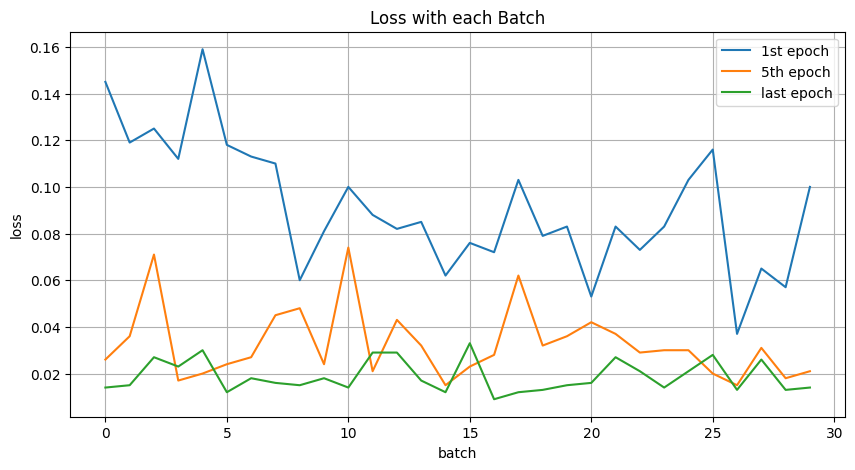

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(overall[0], label='1st epoch')
plt.plot(overall[1], label='5th epoch')
plt.plot(overall[2], label='last epoch')
plt.xlabel('batch')
plt.ylabel('loss')
plt.title('Loss with each Batch')
plt.legend()
plt.grid(True)
plt.savefig("batchLoss.png")
plt.show()

## avrage of loss for each epoch

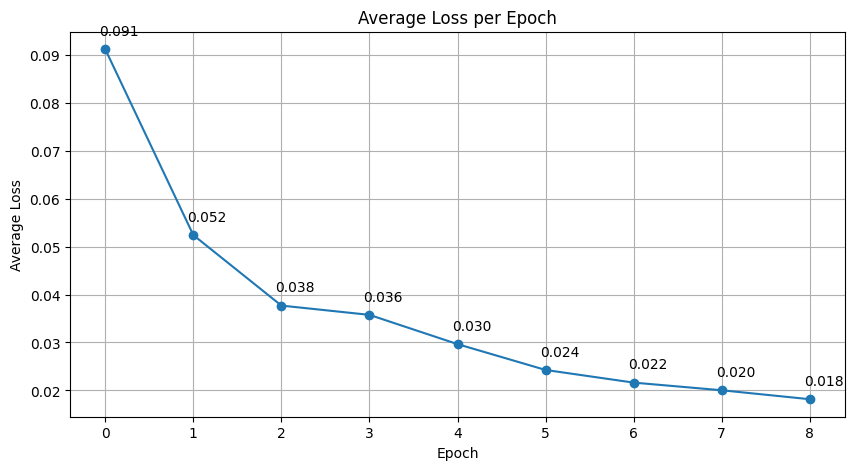

In [ ]:
plt.figure(figsize=(10,5))
avgLossEpoch = [0.091174,0.052402,0.037696,0.035760,0.029656,0.024266,0.021628,0.020031,0.018163]
plt.plot(avgLossEpoch, marker='o')
for i, value in enumerate(avgLossEpoch):
    plt.annotate(f'{value:.3f}', (i, value), textcoords="offset points", xytext=(10,10), ha='center')

plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Average Loss per Epoch')
plt.grid(True)
plt.savefig("AvgLoss.png")
plt.show()

# CarFeatures&B-Box ***Evaluation***

In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

test_dataset = Dataset_cars(data='test', test_size=0.2, transform=transform)
testLoader = DataLoader(test_dataset, batch_size=15, shuffle=True)
mAP_list = []

for i in range(7):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    num_classes = 13  # 1 Background + 12 vehicle class
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    model_epoch=f'/content/drive/MyDrive/DeepLearning_uniCourse_proj/models_epochBased/fasterRCNN_modelEpoch_{i}.pth'
    model.load_state_dict(torch.load(model_epoch))
    model.eval()
    model.to(device)

    metric = MeanAveragePrecision()
    count=0
    for images, targets in testLoader:
        count+=1
        if count%100==0:
            print(f"{count} ", end=" ")
        images = list(image.to(device) for image in images)
        targets1=[]
        for i in range(targets['boxes'].shape[0]):
          targets1.append({'boxes': targets['boxes'][i].to(device).unsqueeze(0), 'labels': targets['labels'][i].to(device).unsqueeze(0)})
        with torch.no_grad():
            preds = model(images)

        # Convert targets to a list of dictionaries if it's not already
        if isinstance(targets, dict):
            targets = [targets]  # Wrap the dictionary in a list

        metric.update(preds, targets1)
    mAP_metric = metric.compute()
    mAP_list.append(mAP_metric)
    print()
    print(f"mAP: {mAP_metric}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-11-1dae19494937>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untruste

<All keys matched successfully>

In [ ]:
def tensor(num):
  return num

In [ ]:
# EPOCH: 1
mAP0= {'map': tensor(0.5413), 'map_50': tensor(0.6047), 'map_75': tensor(0.5938),
      'map_small': tensor(-1.), 'map_medium': tensor(-1.), 'map_large': tensor(0.5415),
      'mar_1': tensor(0.7855), 'mar_10': tensor(0.7855), 'mar_100': tensor(0.7855),
      'mar_small': tensor(-1.), 'mar_medium': tensor(-1.), 'mar_large': tensor(0.7855),
      'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.),
      'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])}

In [ ]:
# EPOCH: 2
mAP1= {'map': tensor(0.5142), 'map_50': tensor(0.5938), 'map_75': tensor(0.5786),
      'map_small': tensor(-1.), 'map_medium': tensor(-1.), 'map_large': tensor(0.5142),
      'mar_1': tensor(0.7914), 'mar_10': tensor(0.7915), 'mar_100': tensor(0.7915),
      'mar_small': tensor(-1.), 'mar_medium': tensor(-1.), 'mar_large': tensor(0.7915),
      'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.),
      'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])}

In [ ]:
# EPOCH: 3
mAP2= {'map': tensor(0.5555), 'map_50': tensor(0.6237), 'map_75': tensor(0.6067),
      'map_small': tensor(-1.), 'map_medium': tensor(-1.), 'map_large': tensor(0.5555),
      'mar_1': tensor(0.7820), 'mar_10': tensor(0.7820), 'mar_100': tensor(0.7820),
      'mar_small': tensor(-1.), 'mar_medium': tensor(-1.), 'mar_large': tensor(0.7820),
      'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.),
      'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])}

In [ ]:
# EPOCH: 4
mAP3= {'map': tensor(0.6350), 'map_50': tensor(0.7147), 'map_75': tensor(0.7059),
      'map_small': tensor(-1.), 'map_medium': tensor(-1.), 'map_large': tensor(0.6350),
      'mar_1': tensor(0.8069), 'mar_10': tensor(0.8071), 'mar_100': tensor(0.8071),
      'mar_small': tensor(-1.), 'mar_medium': tensor(-1.), 'mar_large': tensor(0.8071),
      'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.),
      'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])}

In [ ]:
# EPOCH: 5
mAP4= {'map': tensor(0.6359), 'map_50': tensor(0.7104), 'map_75': tensor(0.6984),
      'map_small': tensor(-1.), 'map_medium': tensor(-1.), 'map_large': tensor(0.6359),
      'mar_1': tensor(0.7949), 'mar_10': tensor(0.7955), 'mar_100': tensor(0.7955),
      'mar_small': tensor(-1.), 'mar_medium': tensor(-1.), 'mar_large': tensor(0.7955),
      'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.),
      'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])}

In [ ]:
# EPOCH: 6
mAP5= {'map': tensor(0.7033), 'map_50': tensor(0.7583), 'map_75': tensor(0.7430),
      'map_small': tensor(-1.), 'map_medium': tensor(-1.), 'map_large': tensor(0.7033),
      'mar_1': tensor(0.8522), 'mar_10': tensor(0.8523), 'mar_100': tensor(0.8523),
      'mar_small': tensor(-1.), 'mar_medium': tensor(-1.), 'mar_large': tensor(0.8523),
      'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.),
      'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])}

In [ ]:
# EPOCH: 7
mAP6= {'map': tensor(0.7480), 'map_50': tensor(0.7968), 'map_75': tensor(0.7840),
      'map_small': tensor(-1.), 'map_medium': tensor(-1.), 'map_large': tensor(0.7480),
      'mar_1': tensor(0.8485), 'mar_10': tensor(0.8487), 'mar_100': tensor(0.8487),
      'mar_small': tensor(-1.), 'mar_medium': tensor(-1.), 'mar_large': tensor(0.8487),
      'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.),
      'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])}

In [ ]:
overall_mAP={'map':[], 'map50':[], 'map75':[], 'mar1':[], 'mar10':[], 'mar100':[]}
for i in [mAP0,mAP1,mAP2,mAP3,mAP4,mAP5,mAP6]:
  overall_mAP['map'].append(i['map'])
  overall_mAP['map50'].append(i['map_50'])
  overall_mAP['map75'].append(i['map_75'])
  overall_mAP['mar1'].append(i['mar_1'])
  overall_mAP['mar10'].append(i['mar_10'])
  overall_mAP['mar100'].append(i['mar_100'])


In [ ]:
for i, value in enumerate(overall_mAP):
    plt.annotate(f'{value:.3f}', (i, value), textcoords="offset points", xytext=(10,10), ha='center')


In [ ]:
overall_mAP

{'map': [0.5413, 0.5142, 0.5555, 0.635, 0.6359, 0.7033, 0.748],
 'map50': [0.6047, 0.5938, 0.6237, 0.7147, 0.7104, 0.7583, 0.7968],
 'map75': [0.5938, 0.5786, 0.6067, 0.7059, 0.6984, 0.743, 0.784],
 'mar1': [0.7855, 0.7914, 0.782, 0.8069, 0.7949, 0.8522, 0.8485],
 'mar10': [0.7855, 0.7915, 0.782, 0.8071, 0.7955, 0.8523, 0.8487],
 'mar100': [0.7855, 0.7915, 0.782, 0.8071, 0.7955, 0.8523, 0.8487]}

In [ ]:
overall_mAP['map75'][-1]

0.784

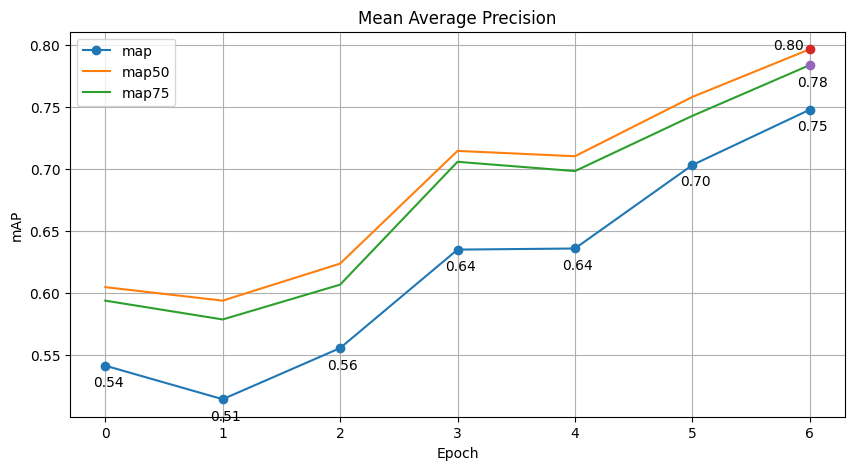

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(overall_mAP['map'], label='map', marker='o')
plt.plot(overall_mAP['map50'], label='map50')
plt.plot(overall_mAP['map75'], label='map75')

for i, value in enumerate(overall_mAP['map']):
  plt.annotate(f'{value:.2f}', (i,value), textcoords="offset points", xytext=(2,-15), ha='center')

plt.plot(6, overall_mAP['map50'][-1], marker='o')
plt.plot(6, overall_mAP['map75'][-1], marker='o')
plt.annotate(f"{overall_mAP['map50'][-1]:.2f}", (6,overall_mAP['map50'][-1]), textcoords="offset points", xytext=(-15,0), ha='center')
plt.annotate(f"{overall_mAP['map75'][-1]:.2f}", (6,overall_mAP['map75'][-1]), textcoords="offset points", xytext=(2,-15), ha='center')

# for i, value in enumerate(overall_mAP['map50']):
#   plt.annotate(f'{value:.3f}', (i,value), textcoords="offset points", xytext=(10,10), ha='center')

plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Mean Average Precision')
plt.legend()
plt.grid(True)
plt.savefig("mAP.png")
plt.show()

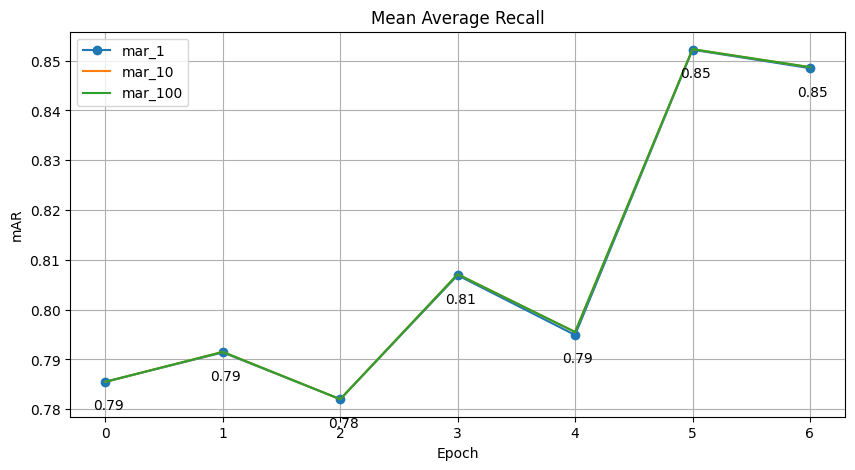

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(overall_mAP['mar1'], label='mar_1', marker='o')
plt.plot(overall_mAP['mar10'], label='mar_10')
plt.plot(overall_mAP['mar100'], label='mar_100')

for ind, value in enumerate(overall_mAP['mar1']):
  plt.annotate(f'{value:.2f}', (ind,value), textcoords="offset points", xytext=(2,-20), ha='center')

plt.xlabel('Epoch')
plt.ylabel('mAR')
plt.title('Mean Average Recall')
plt.grid(True)
plt.legend()
plt.savefig("mAR.png")
plt.show()

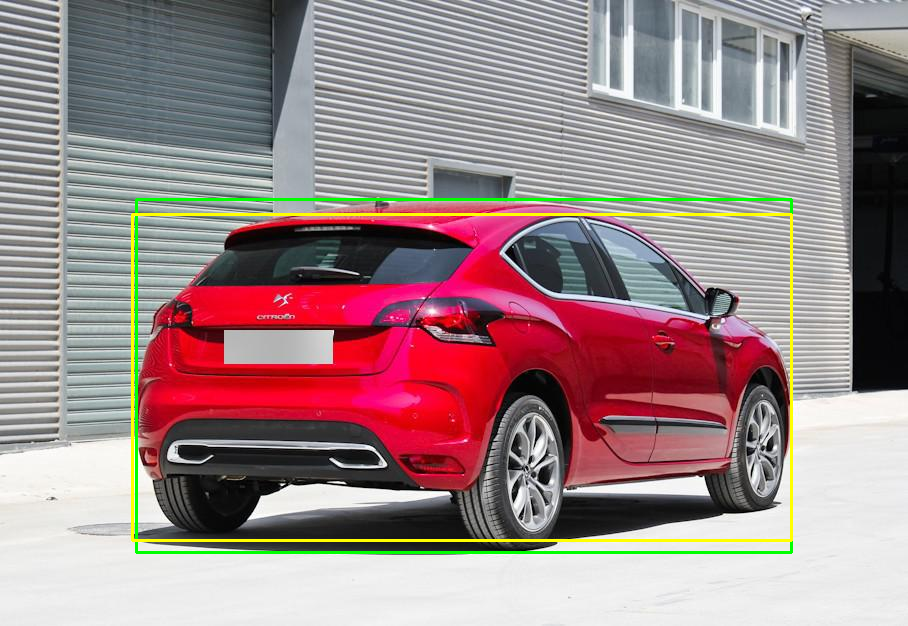

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

image, target = test_dataset[2000]
image_np = image.permute(1, 2, 0).numpy()

# Convert the image to the correct data type and color space
image_np = (image_np * 255).astype('uint8')  # Scale and convert to uint8
image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR) # Convert to BGR if it's RGB

bbox = target['boxes'].numpy().astype(int)

# Now draw the rectangle on a copy
image_np_copy = image_np.copy() #Creating a copy of the image
cv2.rectangle(image_np_copy, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
cv2.rectangle(image_np_copy, (132, 214), (791, 540), (0, 255, 255), 2)

cv2_imshow(image_np_copy)  #Displaying the copy of the image

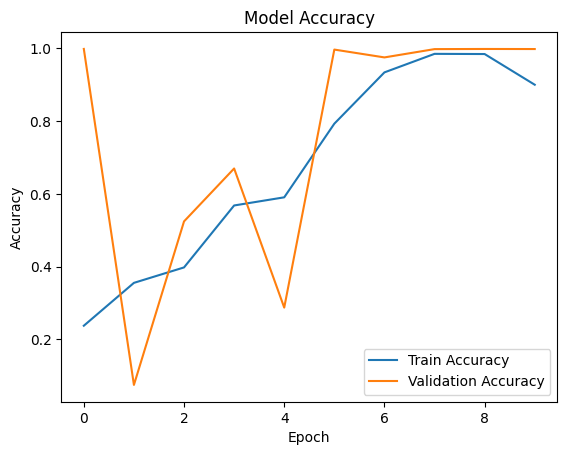

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


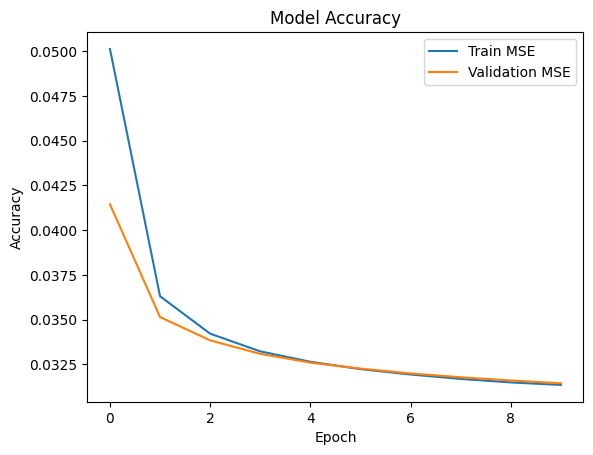

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


# **Car License Plate**


In [ ]:
import kagglehub
path = kagglehub.dataset_download("fareselmenshawii/large-license-plate-dataset")
print("Path to dataset files:", path)

100%|██████████| 2.35G/2.35G [02:18<00:00, 18.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fareselmenshawii/large-license-plate-dataset/versions/1


In [ ]:
mv /root/.cache/kagglehub/datasets/fareselmenshawii/large-license-plate-dataset/versions/1 .

In [ ]:
cd drive/MyDrive/DeepLearning_uniCourse_proj

/content/drive/MyDrive/DeepLearning_uniCourse_proj


In [ ]:
ls

data.yaml                                   DeepLearning_uniProj.ipynb      models_epochBased/
DeepLearning_classificationTechniques.gdoc  efficientnet_compcars_model.h5


Class: 0, Box: (647, 672, 739, 717)


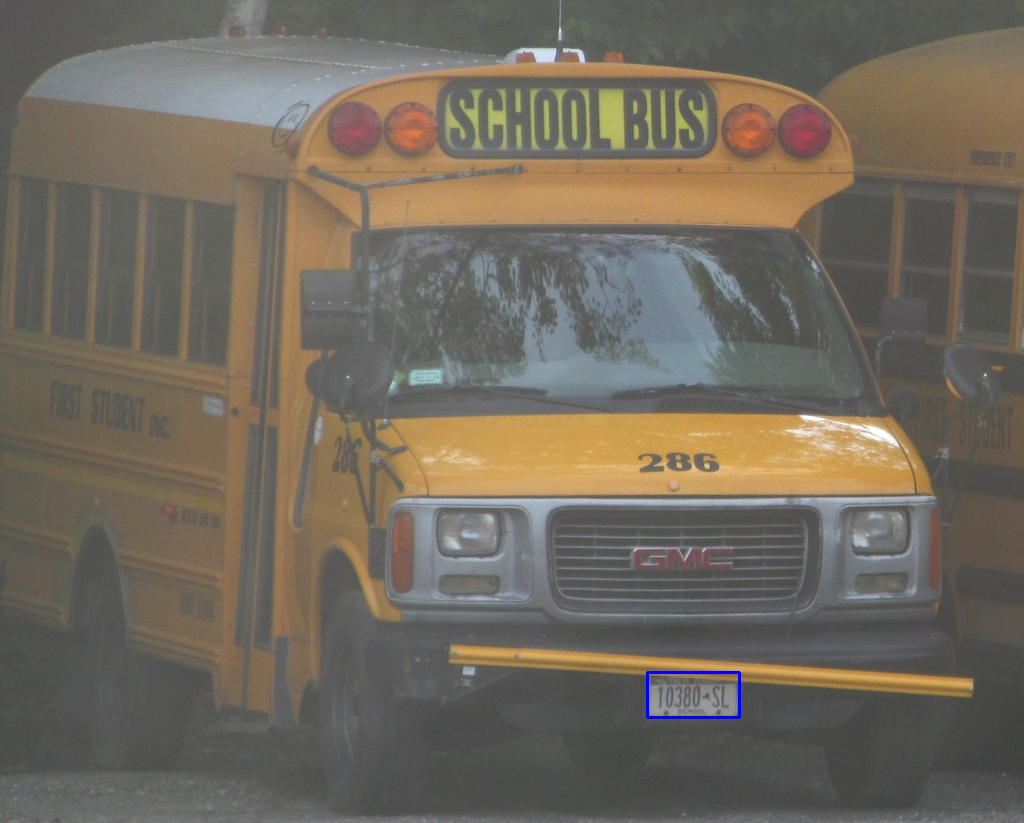

In [ ]:
import cv2

# Example label
label = [0, 0.676796875, 0.8446304702308628, 0.09000000000000008, 0.05525299999999997]

def denormalize_label(label, img_width, img_height):
    class_id, x_center, y_center, width, height = label

    # Convert normalized values to pixel coordinates
    x_center_pixel = int(x_center * img_width)
    y_center_pixel = int(y_center * img_height)
    width_pixel = int(width * img_width)
    height_pixel = int(height * img_height)

    # Calculate top-left and bottom-right corners
    x_min = int(x_center_pixel - width_pixel / 2)
    y_min = int(y_center_pixel - height_pixel / 2)
    x_max = int(x_center_pixel + width_pixel / 2)
    y_max = int(y_center_pixel + height_pixel / 2)

    return class_id, x_min, y_min, x_max, y_max

# Load the image
img = cv2.imread("plate3.jpg")
height, width, _ = img.shape

# Denormalize
class_id, x_min, y_min, x_max, y_max = denormalize_label(label, width, height)
print(f"Class: {class_id}, Box: ({x_min}, {y_min}, {x_max}, {y_max})")

# Visualize bounding box
cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
cv2_imshow(img)

In [ ]:
from ultralytics import YOLO

# Initialize the YOLO model with a pre-trained YOLOv8n checkpoint
model = YOLO('yolov8n.pt')  # Choose from 'yolov8n.pt', 'yolov8s.pt', 'yolov8m.pt', etc.

# Train the model
model.train(
    data='data.yaml',  # Path to your dataset configuration file
    epochs=50,                # Number of training epochs
    imgsz=640,                # Image size
    batch=16,                 # Batch size
    name='car_plate_detector' # Name of the training run
)

# Evaluate the model
metrics = model.val()

# Export the trained model for deployment
model.export(format='onnx')  # Options include 'onnx', 'torchscript', 'coreml', etc.


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 196MB/s]


Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=car_plate_detector, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

100%|██████████| 755k/755k [00:00<00:00, 113MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 191MB/s]


AMP: checks passed ✅


train: Scanning /content/dataset/labels/train... 25470 images, 18 backgrounds, 0 corrupt: 100%|██████████| 25470/25470 [00:29<00:00, 870.99it/s] 


train: New cache created: /content/dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/dataset/labels/val... 1073 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1073/1073 [00:01<00:00, 746.10it/s]

val: New cache created: /content/dataset/labels/val.cache


Plotting labels to runs/detect/car_plate_detector/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/car_plate_detector
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.15G      1.258      1.447       1.15         27        640: 100%|██████████| 1592/1592 [09:48<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:17<00:00,  1.95it/s]


                   all       1073       1573      0.709      0.565      0.618      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.14G      1.252     0.7869      1.148         20        640: 100%|██████████| 1592/1592 [09:52<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:13<00:00,  2.55it/s]

                   all       1073       1573      0.735      0.627      0.658      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.21G      1.281     0.7668      1.175         20        640: 100%|██████████| 1592/1592 [09:38<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:15<00:00,  2.14it/s]

                   all       1073       1573      0.653      0.591      0.595      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.13G      1.283     0.7578      1.192         21        640: 100%|██████████| 1592/1592 [09:22<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:14<00:00,  2.31it/s]

                   all       1073       1573      0.768      0.623      0.671      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.13G      1.256     0.7076      1.178         23        640: 100%|██████████| 1592/1592 [09:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:15<00:00,  2.24it/s]


                   all       1073       1573      0.772      0.668      0.701      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.13G      1.226     0.6688       1.16         22        640: 100%|██████████| 1592/1592 [09:34<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:13<00:00,  2.53it/s]

                   all       1073       1573      0.808      0.658      0.704      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.13G      1.211     0.6444       1.15         18        640: 100%|██████████| 1592/1592 [09:29<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:15<00:00,  2.23it/s]


                   all       1073       1573       0.81      0.682      0.729      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.13G      1.198     0.6241      1.142         23        640: 100%|██████████| 1592/1592 [09:30<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:14<00:00,  2.28it/s]

                   all       1073       1573      0.772      0.689      0.724      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.13G      1.187     0.6096      1.137         20        640: 100%|██████████| 1592/1592 [09:28<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]

                   all       1073       1573      0.823      0.703      0.763      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.13G      1.174     0.5963      1.129         25        640: 100%|██████████| 1592/1592 [09:37<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:13<00:00,  2.50it/s]

                   all       1073       1573      0.809      0.726      0.765      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.13G       1.17     0.5877       1.13         31        640: 100%|██████████| 1592/1592 [09:38<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:15<00:00,  2.16it/s]

                   all       1073       1573      0.817      0.711      0.769      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.13G      1.159     0.5766      1.121         26        640: 100%|██████████| 1592/1592 [09:17<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:14<00:00,  2.29it/s]

                   all       1073       1573      0.846      0.722      0.786        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.17G      1.154       0.57      1.121         30        640: 100%|██████████| 1592/1592 [08:48<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:12<00:00,  2.65it/s]

                   all       1073       1573      0.839      0.738       0.79      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.13G      1.151     0.5646      1.117         15        640: 100%|██████████| 1592/1592 [08:50<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:14<00:00,  2.35it/s]

                   all       1073       1573      0.832      0.747      0.795      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.13G      1.141     0.5529      1.112         24        640: 100%|██████████| 1592/1592 [08:52<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:12<00:00,  2.66it/s]

                   all       1073       1573      0.851      0.745      0.789      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.14G      1.144     0.5512      1.113         24        640: 100%|██████████| 1592/1592 [08:50<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:15<00:00,  2.21it/s]

                   all       1073       1573      0.831      0.771      0.807      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.13G      1.135     0.5416       1.11         26        640: 100%|██████████| 1592/1592 [08:51<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:12<00:00,  2.65it/s]

                   all       1073       1573      0.841      0.763      0.814      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.13G      1.127     0.5389      1.105         28        640: 100%|██████████| 1592/1592 [09:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:13<00:00,  2.45it/s]

                   all       1073       1573      0.842      0.767      0.811      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.14G      1.128     0.5372      1.108         24        640: 100%|██████████| 1592/1592 [09:16<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:13<00:00,  2.55it/s]

                   all       1073       1573      0.809      0.781      0.808      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.13G      1.119     0.5287      1.102         26        640: 100%|██████████| 1592/1592 [09:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:13<00:00,  2.47it/s]

                   all       1073       1573      0.819      0.791      0.827       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.13G       1.12     0.5278      1.098         26        640: 100%|██████████| 1592/1592 [09:03<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:14<00:00,  2.29it/s]

                   all       1073       1573      0.847      0.778      0.829       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.14G      1.123     0.5223      1.101         27        640: 100%|██████████| 1592/1592 [09:13<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:15<00:00,  2.23it/s]

                   all       1073       1573       0.84      0.791      0.833      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.13G      1.114     0.5182      1.098         23        640: 100%|██████████| 1592/1592 [09:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:13<00:00,  2.60it/s]

                   all       1073       1573      0.858      0.777      0.829      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.15G       1.11     0.5128      1.094         23        640: 100%|██████████| 1592/1592 [09:04<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:14<00:00,  2.28it/s]

                   all       1073       1573      0.851      0.786      0.831      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.17G      1.105     0.5092      1.091         25        640: 100%|██████████| 1592/1592 [08:56<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:12<00:00,  2.77it/s]

                   all       1073       1573       0.86       0.79      0.837      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.13G      1.101     0.5024       1.09         25        640: 100%|██████████| 1592/1592 [09:00<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:15<00:00,  2.26it/s]

                   all       1073       1573       0.83      0.802      0.836      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.13G      1.098     0.5011      1.089         25        640: 100%|██████████| 1592/1592 [08:58<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:14<00:00,  2.39it/s]

                   all       1073       1573       0.84      0.792      0.837      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.14G      1.098     0.4978      1.085         28        640: 100%|██████████| 1592/1592 [09:11<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:15<00:00,  2.17it/s]

                   all       1073       1573      0.847      0.797       0.84      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.13G      1.086     0.4922      1.083         28        640: 100%|██████████| 1592/1592 [09:19<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:13<00:00,  2.52it/s]

                   all       1073       1573       0.85      0.791      0.841      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.13G      1.092     0.4898      1.084         22        640: 100%|██████████| 1592/1592 [09:02<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:14<00:00,  2.32it/s]

                   all       1073       1573       0.86      0.779       0.84      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.13G      1.086     0.4869      1.083         37        640: 100%|██████████| 1592/1592 [09:01<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:14<00:00,  2.38it/s]

                   all       1073       1573      0.832       0.81      0.845       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.13G      1.075      0.478      1.076         29        640: 100%|██████████| 1592/1592 [08:52<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:14<00:00,  2.39it/s]

                   all       1073       1573      0.845      0.805      0.846       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.13G      1.069     0.4748      1.075         26        640: 100%|██████████| 1592/1592 [08:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:14<00:00,  2.28it/s]

                   all       1073       1573      0.839      0.819      0.849      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.13G      1.067     0.4718      1.072         14        640: 100%|██████████| 1592/1592 [08:48<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:14<00:00,  2.33it/s]

                   all       1073       1573      0.838       0.82      0.847      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.14G      1.064     0.4673      1.073         31        640: 100%|██████████| 1592/1592 [09:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:14<00:00,  2.29it/s]

                   all       1073       1573      0.843      0.815      0.846      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.13G      1.061     0.4626      1.067         24        640: 100%|██████████| 1592/1592 [09:12<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:15<00:00,  2.16it/s]

                   all       1073       1573      0.847      0.815      0.848      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.13G      1.057     0.4579       1.07         29        640: 100%|██████████| 1592/1592 [09:07<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:14<00:00,  2.27it/s]

                   all       1073       1573      0.847      0.811      0.845      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.13G      1.057     0.4586       1.07         20        640: 100%|██████████| 1592/1592 [08:58<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:12<00:00,  2.73it/s]

                   all       1073       1573      0.842      0.811      0.844       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.13G      1.047     0.4499      1.063         24        640: 100%|██████████| 1592/1592 [08:56<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:15<00:00,  2.25it/s]

                   all       1073       1573      0.845      0.809      0.846      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.13G      1.041     0.4464      1.065         23        640: 100%|██████████| 1592/1592 [08:56<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:12<00:00,  2.65it/s]


                   all       1073       1573      0.851      0.804      0.845      0.453
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.13G      1.028     0.4026      1.088         18        640: 100%|██████████| 1592/1592 [08:42<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:15<00:00,  2.20it/s]

                   all       1073       1573      0.849      0.807      0.845      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.13G       1.02     0.3973      1.084         16        640: 100%|██████████| 1592/1592 [08:39<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:15<00:00,  2.23it/s]

                   all       1073       1573      0.844      0.808      0.843      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.13G      1.013     0.3923      1.078         15        640: 100%|██████████| 1592/1592 [08:40<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:12<00:00,  2.71it/s]

                   all       1073       1573      0.843      0.811      0.843      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.13G      1.005     0.3886      1.073         15        640: 100%|██████████| 1592/1592 [08:41<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:11<00:00,  2.86it/s]

                   all       1073       1573      0.843      0.806      0.843      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.13G     0.9971     0.3831       1.07         16        640: 100%|██████████| 1592/1592 [08:40<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:15<00:00,  2.20it/s]


                   all       1073       1573      0.843      0.808      0.843      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.13G     0.9921     0.3789      1.067         14        640: 100%|██████████| 1592/1592 [08:36<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:13<00:00,  2.50it/s]

                   all       1073       1573      0.843      0.808      0.844      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.13G     0.9861      0.373      1.064         15        640: 100%|██████████| 1592/1592 [08:36<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:12<00:00,  2.81it/s]


                   all       1073       1573      0.845      0.809      0.845      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.13G     0.9776     0.3686      1.061         18        640: 100%|██████████| 1592/1592 [08:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:14<00:00,  2.35it/s]

                   all       1073       1573      0.847      0.808      0.846      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.13G     0.9702     0.3654      1.058         15        640: 100%|██████████| 1592/1592 [08:42<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:14<00:00,  2.29it/s]


                   all       1073       1573       0.85      0.804      0.847      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.13G     0.9654     0.3626      1.052         15        640: 100%|██████████| 1592/1592 [08:35<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:15<00:00,  2.20it/s]

                   all       1073       1573       0.85      0.803      0.847      0.459



50 epochs completed in 7.780 hours.
Optimizer stripped from runs/detect/car_plate_detector/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/car_plate_detector/weights/best.pt, 6.2MB

Validating runs/detect/car_plate_detector/weights/best.pt...
Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:16<00:00,  2.04it/s]


                   all       1073       1573       0.85      0.802      0.846      0.459
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/car_plate_detector
Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/dataset/labels/val.cache... 1073 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1073/1073 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:19<00:00,  3.55it/s]


                   all       1073       1573      0.851      0.803      0.847      0.461
Speed: 0.3ms preprocess, 4.7ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/car_plate_detector2
Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/detect/car_plate_detector/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.9 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 187.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 229.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 173.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 191.8 MB/s eta 0:00:00

requirements: AutoU

'runs/detect/car_plate_detector/weights/best.onnx'

In [ ]:
from google.colab import runtime
runtime.unassign()

# Conjunction of all **Trained Models**

# Final Stage

In [ ]:
!pip install easyocr
!pip install ultralytics
!pip install paddleocr
!pip install paddlepaddle

import ultralytics
from ultralytics import YOLO
import easyocr
import torch
import torchvision
from torchvision import transforms
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
from paddleocr import PaddleOCR
import numpy as np

car_detect_model_adres = "drive/MyDrive/DeepLearning_uniCourse_proj/models_epochBased/fasterRCNN_modelEpoch_7.pth"
plate_detect_model_adres = "drive/MyDrive/DeepLearning_uniCourse_proj/runs/detect/car_plate_detector/weights/best.pt"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: opt-einsum
    Found existing installation: opt_einsum 3.4.0
    Uninstalling opt_einsum-3.4.0:
      Successfully uninstalled opt_einsum-3.4.0


### loading RCNN_carDetection model

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
class_numbers = 13
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, class_numbers)
model.load_state_dict(torch.load(car_detect_model_adres))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

### loading YOLO_plateDetection model

In [ ]:
plate_detect_model = YOLO(plate_detect_model_adres)
plate_detect_model.to('cuda')
plate_detect_model.eval()

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

### loading PaddleOCR_plateReader model

In [ ]:
ocr = PaddleOCR(use_angle_cls=True, lang='en')  # Set language to 'en'

download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 3910/3910 [00:00<00:00, 4675.89it/s]


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10000/10000 [00:01<00:00, 9895.26it/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2138/2138 [00:00<00:00, 2930.57it/s]

[2024/11/27 19:19:45] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

### load the image

In [ ]:
image = cv2.imread("car2.png")

### carDetection

In [ ]:
image_transformed = torchvision.transforms.ToTensor()(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)).unsqueeze(0)
outputs = model(image_transformed)

In [ ]:
carType = {1: 'MPV', 2: 'SUV', 3: 'sedan', 4: 'hatchback', 5: 'minibus', 6: 'fastback', 7: 'estate',
            8: 'pickup', 9: 'hardtop convertible', 10: 'sports', 11: 'crossover', 12: 'convertible'}
output = outputs[0]
max_score_ind= torch.argmax(output['scores']).item()
bbox_car = output['boxes'][max_score_ind].detach().numpy().astype(int)
lbl_car = carType[output['labels'][max_score_ind].item()]
acc_score_car = output['scores'][max_score_ind].item()

output

{'boxes': tensor([[ 248.0993,  135.8169, 1117.8687,  677.7188],
         [ 274.6505,  184.8157, 1115.4564,  666.0967],
         [ 274.4810,  157.3006, 1122.0000,  664.7659],
         [ 280.2639,  139.1139, 1105.2354,  682.4816],
         [ 265.6866,  190.6676, 1120.8236,  669.0153],
         [ 234.6966,  155.2562, 1122.0000,  658.3441],
         [ 285.1493,  153.3700, 1111.0171,  693.4877]], grad_fn=<StackBackward0>),
 'labels': tensor([ 4,  6,  3, 10,  7,  9, 12]),
 'scores': tensor([0.9091, 0.5970, 0.4343, 0.2014, 0.1222, 0.0670, 0.0521], grad_fn=<IndexBackward0>)}

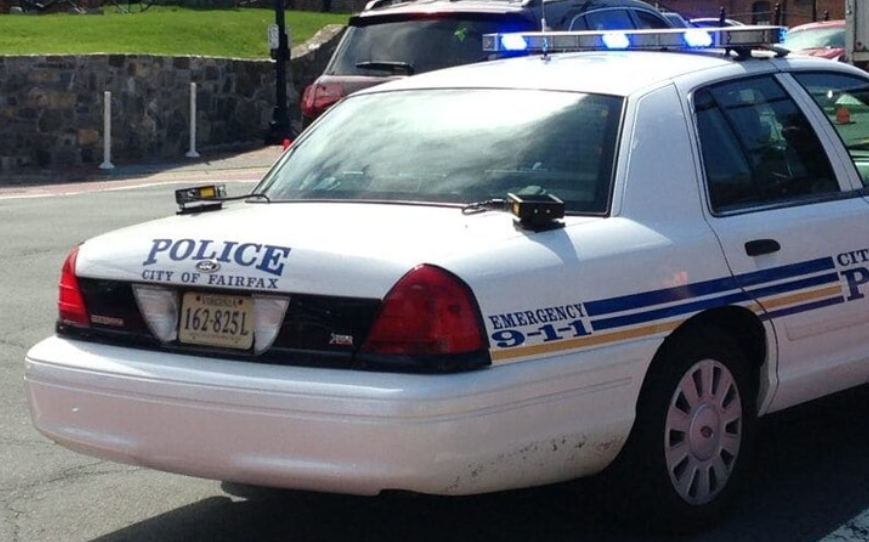

hatchback 0.91


In [ ]:
carDetected_img = image[bbox_car[1]:bbox_car[3], bbox_car[0]:bbox_car[2]]
cv2_imshow(carDetected_img)
print(lbl_car, "{:.2f}".format(acc_score_car))

In [ ]:
def preprocess(image, img_size=640):
    image = Image.fromarray(image).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

transformed_image = preprocess(carDetected_img)
with torch.no_grad():
  results = plate_detect_model(transformed_image)


0: 640x640 1 license_plate, 10.5ms
Speed: 1.3ms preprocess, 10.5ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)


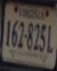

In [ ]:
orig_image = results[0].orig_img.copy()  # Original image as a NumPy array
boxes = results[0].boxes

if boxes is not None:
    for box in boxes:
        # Extract the bounding box coordinates
        x_min, y_min, x_max, y_max = map(int, box.xyxy[0])  # Convert to integers
        confidence = box.conf[0]  # Confidence score
        class_id = int(box.cls[0])  # Class ID
        label = results[0].names[class_id] # class label

        cv2_imshow(results[0].orig_img[y_min:y_max, x_min:x_max])

license_plate = results[0].orig_img[y_min:y_max, x_min:x_max]

In [ ]:
plate_results = ocr.ocr(license_plate, det=True, rec=True)
for line in plate_results[0]:
    print("Detected Text:", line[1][0], "Confidence:", line[1][1])


[2024/11/27 20:39:13] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.04254317283630371
[2024/11/27 20:39:13] ppocr DEBUG: cls num  : 1, elapsed : 0.013419628143310547
[2024/11/27 20:39:13] ppocr DEBUG: rec_res num  : 1, elapsed : 0.044724464416503906
Detected Text: 161-825L Confidence: 0.7802460193634033


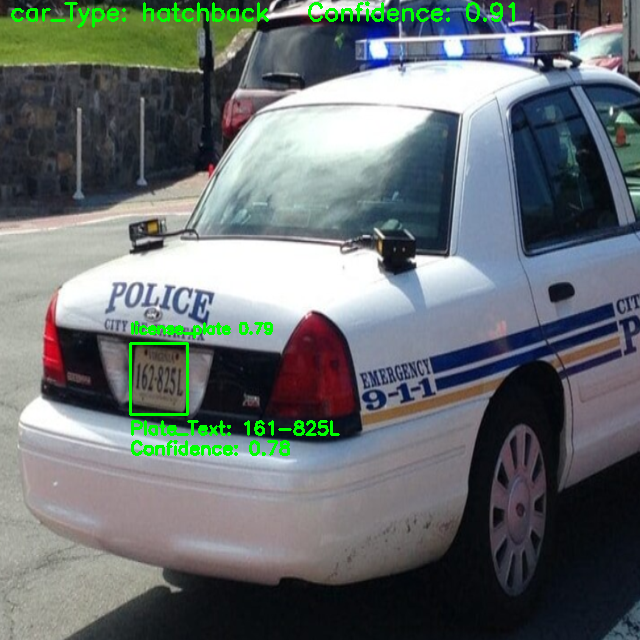

In [ ]:
import cv2
import numpy as np

orig_image = results[0].orig_img.copy()  # Original image as a NumPy array
license_plate = results[0].orig_img[y_min:y_max, x_min:x_max]
boxes = results[0].boxes

if boxes is not None:
    for box in boxes:
        # Extract the bounding box coordinates
        x_min, y_min, x_max, y_max = map(int, box.xyxy[0])  # Convert to integers
        confidence = box.conf[0]  # Confidence score
        class_id = int(box.cls[0])  # Class ID
        label = results[0].names[class_id] # class label

        cv2.rectangle(orig_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        # Add label and confidence
        text = f"{label} {confidence:.2f}"
        cv2.putText(orig_image, text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (0, 255, 0), 2)

        text = f"Plate_Text: {line[1][0]}"
        cv2.putText(orig_image, text, (x_min, y_max + 20), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (0, 255, 0), 2)
        text = f"Confidence: {line[1][1]:.2f}"
        cv2.putText(orig_image, text, (x_min, y_max + 40), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (0, 255, 0), 2)

        # Add label and confidence
        text = f"car_Type: {lbl_car}   Confidence: {acc_score_car:.2f}"
        cv2.putText(orig_image, text, (10, 20), cv2.FONT_HERSHEY_SIMPLEX,
                    0.8, (0, 255, 0), 2)


# Convert the image from BGR to RGB for visualization (cv2 uses BGR by default)
image_rgb = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
plateDetected_image = Image.fromarray(image_rgb)
plateDetected_image

## in one GO!

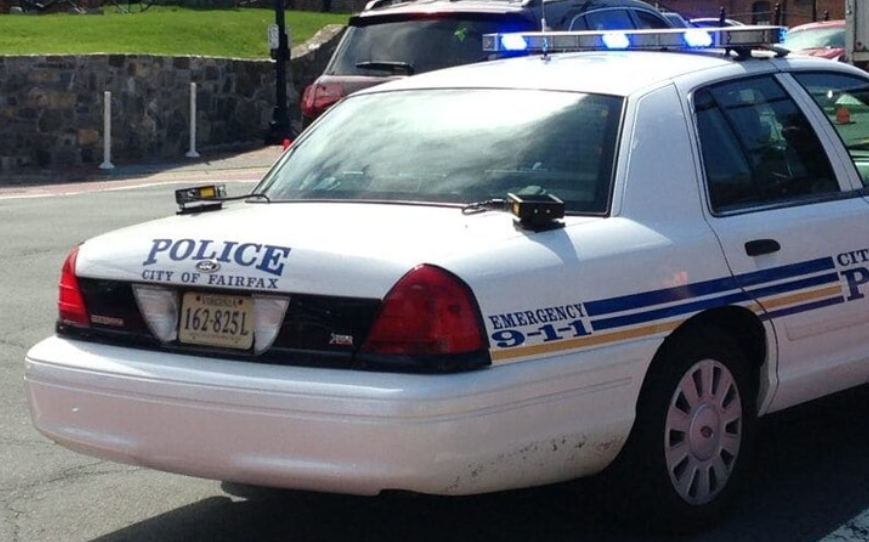

hatchback 0.91

0: 640x640 1 license_plate, 10.0ms
Speed: 1.3ms preprocess, 10.0ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)


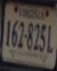

0 license_plate 0.79
[2024/11/27 21:05:13] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.01573038101196289
[2024/11/27 21:05:13] ppocr DEBUG: cls num  : 1, elapsed : 0.010892868041992188
[2024/11/27 21:05:13] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08581089973449707
Detected Text: 161-825L Confidence: 0.7802460193634033


In [ ]:
image = cv2.imread("car2.png")
# Car Detection
image_transformed = torchvision.transforms.ToTensor()(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)).unsqueeze(0)
outputs = model(image_transformed)
carType = {1: 'MPV', 2: 'SUV', 3: 'sedan', 4: 'hatchback', 5: 'minibus', 6: 'fastback', 7: 'estate',
            8: 'pickup', 9: 'hardtop convertible', 10: 'sports', 11: 'crossover', 12: 'convertible'}
output = outputs[0]
max_score_ind= torch.argmax(output['scores']).item()
bbox_car = output['boxes'][max_score_ind].detach().numpy().astype(int)
lbl_car = carType[output['labels'][max_score_ind].item()]
acc_score_car = output['scores'][max_score_ind].item()

cv2_imshow(image[bbox_car[1]:bbox_car[3], bbox_car[0]:bbox_car[2]])
print(lbl_car, "{:.2f}".format(acc_score_car))

# Plate Detection
def preprocess(image, img_size=640):
    image = Image.fromarray(image).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension
transformed_image = preprocess(carDetected_img)
with torch.no_grad():
  results = plate_detect_model(transformed_image)

orig_image = results[0].orig_img.copy()  # Original image as a NumPy array
boxes = results[0].boxes
if boxes is not None:
    for box in boxes:
        x_min, y_min, x_max, y_max = map(int, box.xyxy[0])  # Convert to integers
        confidence = box.conf[0]  # Confidence score
        class_id = int(box.cls[0])  # Class ID
        label = results[0].names[class_id] # class label
        cv2_imshow(results[0].orig_img[y_min:y_max, x_min:x_max])
        print(class_id, label, "{:.2f}".format(confidence.item()))
p
# License Plate Reader
license_plate = results[0].orig_img[y_min:y_max, x_min:x_max]
plate_results = ocr.ocr(license_plate, det=True, rec=True)
for line in plate_results[0]:
    print("Detected Text:", line[1][0], "Confidence:", line[1][1])


In [ ]:
overall_time = 10sec
time_without_ploting_imgs = 4sec